# Get Data



In [0]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
url = 'https://raw.githubusercontent.com/raghav7203/test/master/confirmed25apr.csv?token=ALQ7JJVUG5TA3EP5FW42UKC6V2QMG'
confirmed = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/raghav7203/test/master/deceased25apr.csv?token=ALQ7JJRDW4OBPUVSJKQBLJ26V2QOC'
death = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/raghav7203/test/master/recovered25apr.csv?token=ALQ7JJTXTFKA2GR7NDFXCQS6V2QP2'
recover = pd.read_csv(url, error_bad_lines=False)

## Population

In [0]:
population=pd.read_csv('https://raw.githubusercontent.com/raghav7203/test/master/population.csv?token=ALQ7JJQE74NKKDXOMNM57DS6V2QR6', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [52]:
# merge region
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:5,:]

,Province/State,Country/Region,Lat,Long,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,Population,region
0,Andaman and Nicobar Islands,India,11.667026,92.735983,0,0,0,0,0,0,0,0,0,0,0,0,1,6,9,9,10,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,12,14,15,16,17,18,22,29,33,"380,581",India_Andaman and Nicobar Islands
1,Andhra Pradesh,India,14.750429,78.570026,1,1,1,1,1,3,3,5,6,7,8,10,11,13,19,21,23,44,111,149,164,192,256,303,314,348,363,381,405,420,439,484,525,534,572,603,647,722,757,813,893,955,1016,"49,506,799",India_Andhra Pradesh
2,Arunachal Pradesh,India,27.100399,93.616601,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,"1,383,727",India_Arunachal Pradesh
3,Assam,India,26.244156,92.537842,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,16,16,23,26,26,26,28,28,29,29,29,30,32,33,33,35,35,35,35,35,35,35,36,36,36,"31,205,576",India_Assam
4,Bihar,India,25.785414,87.479973,0,0,0,0,0,0,0,0,2,3,3,4,7,9,11,15,15,21,24,29,31,32,32,32,38,39,48,50,54,54,56,56,62,73,75,76,86,103,116,133,160,213,241,"104,099,452",India_Bihar


## Create Time Series + Plots

In [0]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long','Population'], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [0]:
ts=create_ts(confirmed)
ts_d=create_ts(death)
ts_rec=create_ts(recover)

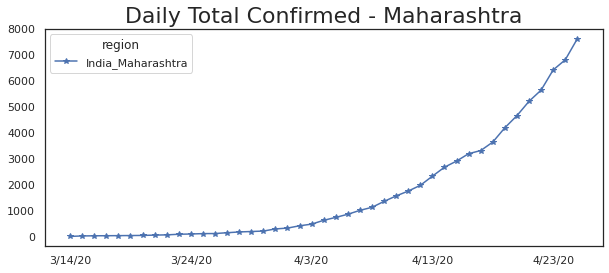

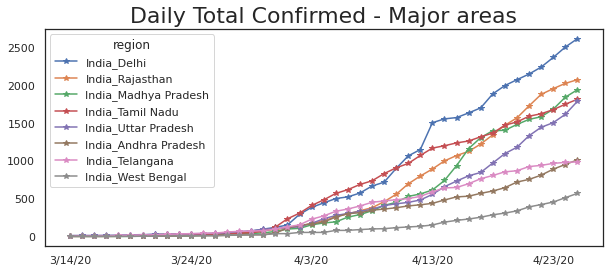

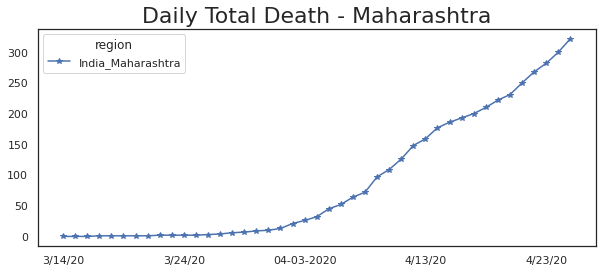

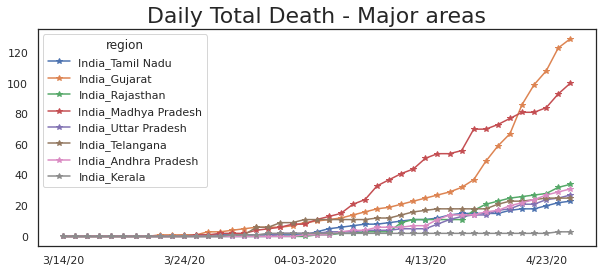

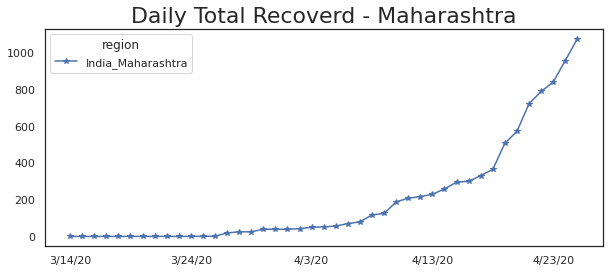

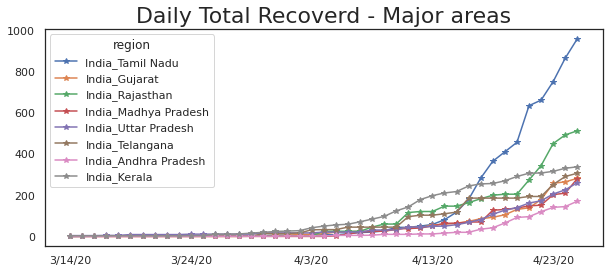

In [55]:
import matplotlib.pyplot as plt
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,:1].plot(marker='*',figsize=(10,4)).set_title('Daily Total Confirmed - Maharashtra',fontdict={'fontsize': 22}).figure.savefig('img1.png')
p.iloc[:,2:10].plot(marker='*',figsize=(10,4)).set_title('Daily Total Confirmed - Major areas',fontdict={'fontsize': 22}).figure.savefig('img2.png')

p_d=ts_d.reindex(ts.mean().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,:1].plot(marker='*',figsize=(10,4)).set_title('Daily Total Death - Maharashtra',fontdict={'fontsize': 22}).figure.savefig('img3.png')
p_d.iloc[:,2:10].plot(marker='*',figsize=(10,4)).set_title('Daily Total Death - Major areas',fontdict={'fontsize': 22}).figure.savefig('img4.png')

p_r=ts_rec.reindex(ts.mean().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,:1].plot(marker='*',figsize=(10,4)).set_title('Daily Total Recoverd - Maharashtra',fontdict={'fontsize': 22}).figure.savefig('img5.png')
p_r.iloc[:,2:10].plot(marker='*',figsize=(10,4)).set_title('Daily Total Recoverd - Major areas',fontdict={'fontsize': 22}).figure.savefig('img6.png')

## Kalman Filter With R


In [56]:
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [57]:
%%R
install.packages('pracma')
install.packages('reshape')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/pracma_2.2.9.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 400551 bytes (391 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

In [58]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("https://raw.githubusercontent.com/raghav7203/test/master/ts_r_25apr.csv?token=ALQ7JJTVZ5ERTKELLIXFIKS6V2QYA")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: Metrics

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  date = col_date(format = "")
)

R[write to console]: See spec(...) for full column specifications.



In [0]:
p=%R pred_all

In [0]:
############ Merge R output due to package problem
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
p.set_index(temp.index,inplace=True)
#temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

## Pre Proccessing Data for ML Model

In [0]:
w=pd.read_csv('https://raw.githubusercontent.com/raghav7203/test/master/w_hist.csv?token=ALQ7JJV3IZFKUEPK2BHBMVK6V2Q7E', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'])
#w['date']=pd.to_datetime(w['date'],errors ='coerce')

w_forecast=pd.read_csv('https://raw.githubusercontent.com/raghav7203/test/master/w_fore.csv?token=ALQ7JJWLGSWHBWWQHLZBY326V2RC2', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'])

## Build Train Set Data Structure

In [0]:
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [63]:
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is t.iloc[i-2,1]):
    t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
    t.iloc[i,6]=(t.iloc[i-1,2]/t.iloc[i-2,2]-1)*100
    t.iloc[i,9]=t.iloc[i-1,2]
  if(t.iloc[i,1] is t.iloc[i-4,1]):
    t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
    t.iloc[i,7]=(t.iloc[i-1,2]/t.iloc[i-4,2]-1)*100
  if(t.iloc[i,1] is t.iloc[i-8,1]):
    t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
    t.iloc[i,8]=(t.iloc[i-1,2]/t.iloc[i-8,2]-1)*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)
t['kalman_prediction']=round(t['kalman_prediction'])
train=t.merge(confirmed[['region','Population']],how='left',on='region')
train=train.rename(columns = {'Population':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(1)
train['population']=train['population'].astype('int32')
train['infected_rate'] =train['last_day']/train['population']*10000
train=train.merge(w,how='left',on=['date','region'])
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
  if(np.isnan(train.iloc[i,13])):
    if(train.iloc[i,1] is train.iloc[i-1,1]):
      train.iloc[i,13]=train.iloc[i-1,13]
      train.iloc[i,14]=train.iloc[i-1,14]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':


## Kalman 1 day Prediction with Evaluation

               region           mse         rmse         mae
21  India_Maharashtra  1.516707e+06  1231.546494  284.162791


,date,region,confirmed,kalman_prediction
958,2020-04-17,India_Maharashtra,3321,3448.0
959,2020-04-18,India_Maharashtra,3648,3652.0
960,2020-04-19,India_Maharashtra,4200,3913.0
961,2020-04-20,India_Maharashtra,4666,4353.0
962,2020-04-21,India_Maharashtra,5218,4852.0
963,2020-04-22,India_Maharashtra,5649,5429.0
964,2020-04-23,India_Maharashtra,6427,5970.0
965,2020-04-24,India_Maharashtra,6817,6690.0
966,2020-04-25,India_Maharashtra,7628,7274.0
967,2020-04-26,India_Maharashtra,0,8016.0


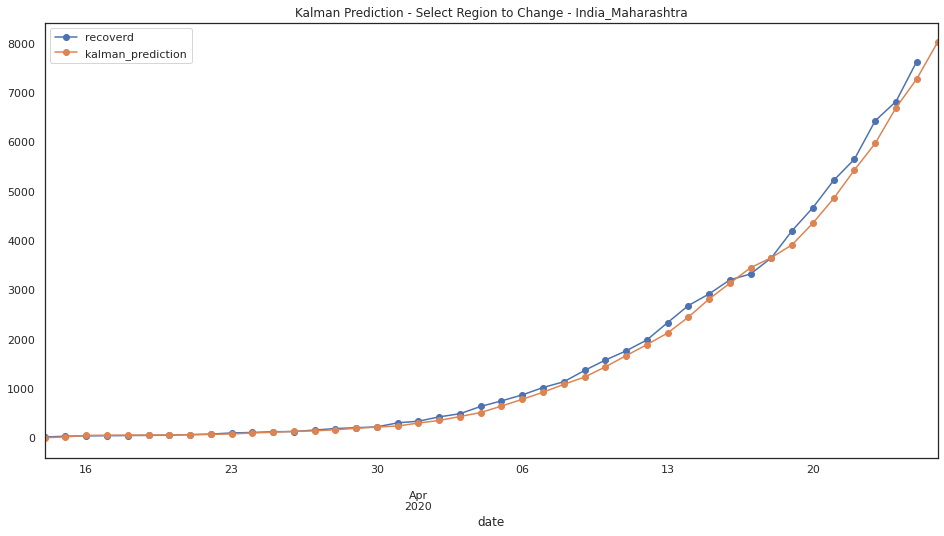

In [64]:
# Select region
region='India_Maharashtra'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0])).figure.savefig('img7.png')
print(evaluation[evaluation['region']==p.iloc[0,0]])
# print(evaluation)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
p.tail(10)

## Correlation Matrix And Temperature

Correlation Matrix


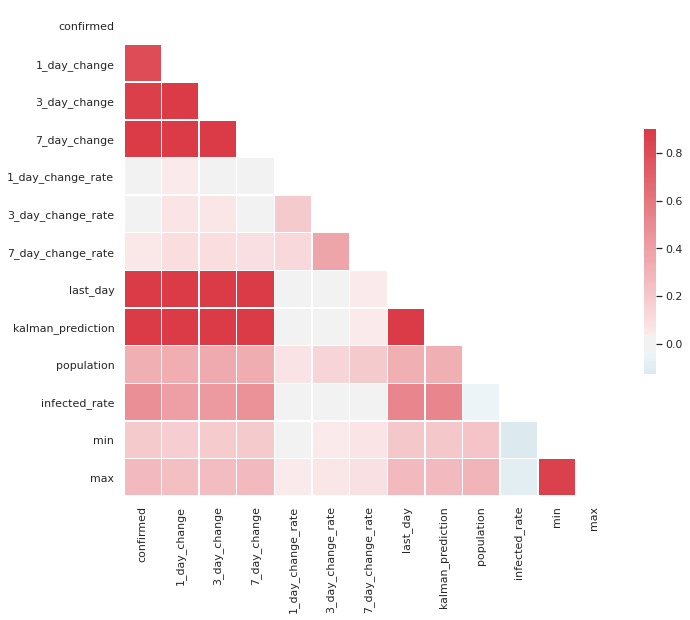

In [65]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).figure.savefig('img8.png')
print ('Correlation Matrix')

In [66]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.814872
3_day_change         0.873031
7_day_change         0.893072
1_day_change_rate   -0.002018
3_day_change_rate    0.014287
7_day_change_rate    0.053823
last_day             0.904870
kalman_prediction    0.905616
population           0.326579
infected_rate        0.482779
min                  0.198725
max                  0.269535
Name: confirmed, dtype: float64


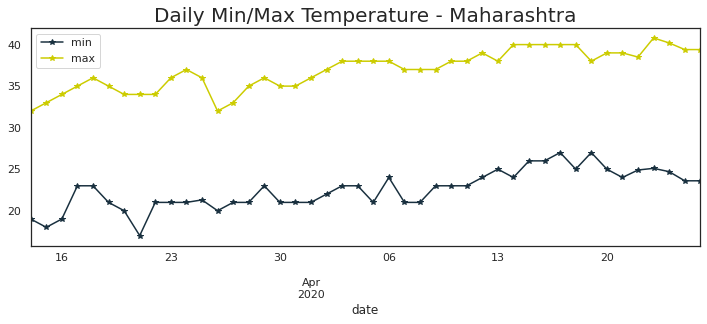

In [67]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
p=p[p['region']=='India_Maharashtra']
p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - Maharashtra',fontdict={'fontsize': 20}).figure.savefig('img9.png')

In [68]:
avg_temp=train[['region','confirmed','min','max']]  # from 17-02-20
avg_temp=avg_temp.groupby(by='region').mean()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:10,1:])

Most infected Areas Avg Temperature
                            min        max
region                                    
India_Maharashtra     22.527273  36.938636
India_Delhi           18.640909  33.600000
India_Tamil Nadu      25.729545  37.986364
India_Gujarat         24.200000  37.688636
India_Rajasthan       22.325000  33.747727
India_Madhya Pradesh  21.165909  35.013636
India_Uttar Pradesh   20.615909  33.536364
India_Telangana       23.384091  35.834091
India_Andhra Pradesh  20.204545  35.134091
India_Kerala          25.670455  35.275000


## Kalman X Days Ahead Prediction

In [69]:
%%R
install.packages('reshape')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/reshape_0.8.8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 42558 bytes (41 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write 

In [70]:
%%R
require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("https://raw.githubusercontent.com/raghav7203/test/master/ts_r_25apr.csv?token=ALQ7JJWI3EZV7QUKIDE4UIK6V2RJA")
all$X1<-NULL
for (i in 1:30) { # Set i days prediction
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

R[write to console]: Loading required package: Metrics

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  date = col_date(format = "")
)

R[write to console]: See spec(...) for full column specifications.



In [0]:
all_new=%R all_new

In [0]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

,India_Maharashtra
date,
2020-04-26,7955.0
2020-04-27,8316.0
2020-04-28,9241.0
2020-04-29,9329.0
2020-04-30,9329.0
2020-05-01,10411.0
2020-05-02,10411.0
2020-05-03,10777.0
2020-05-04,11457.0


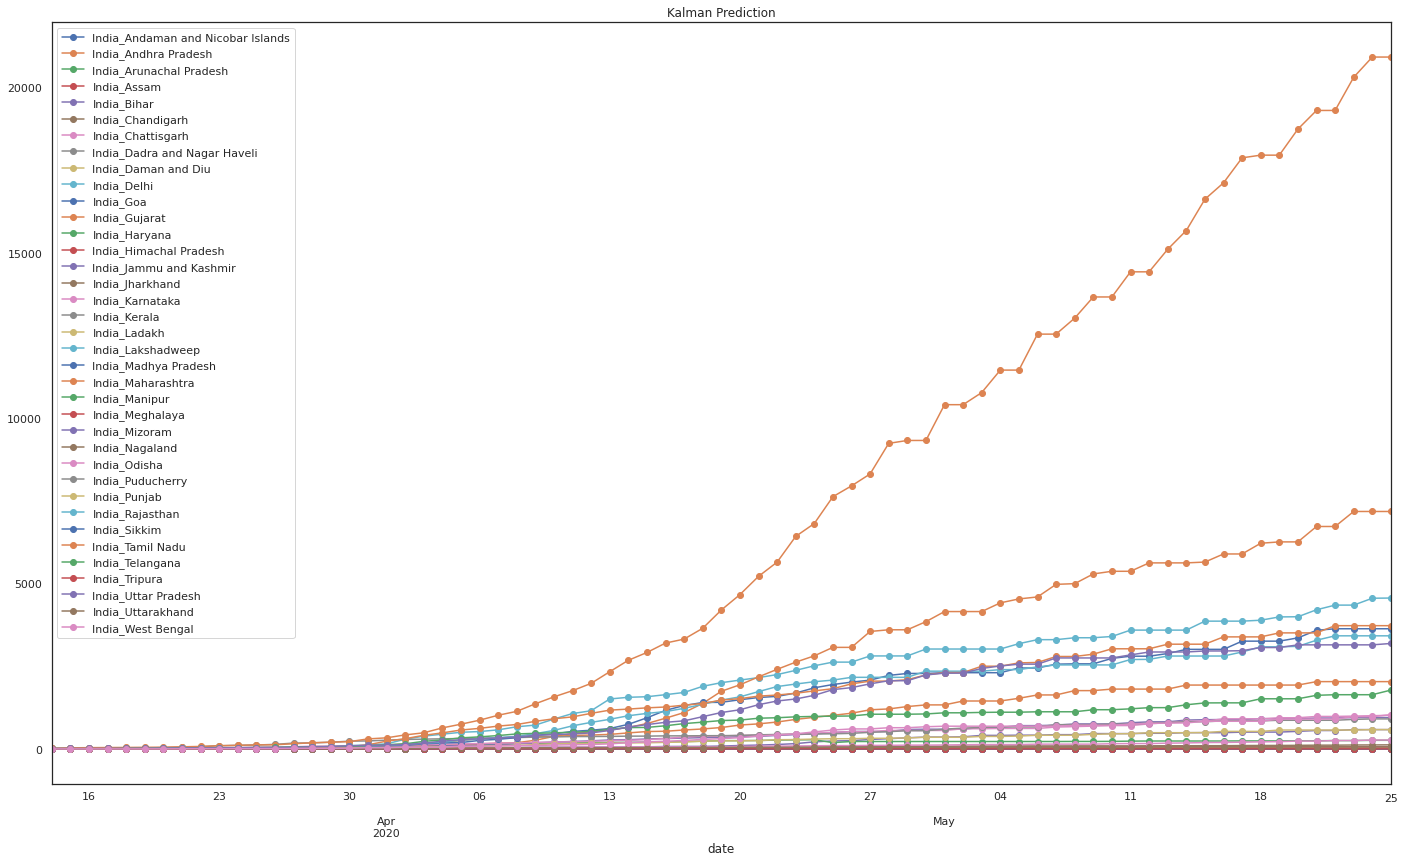

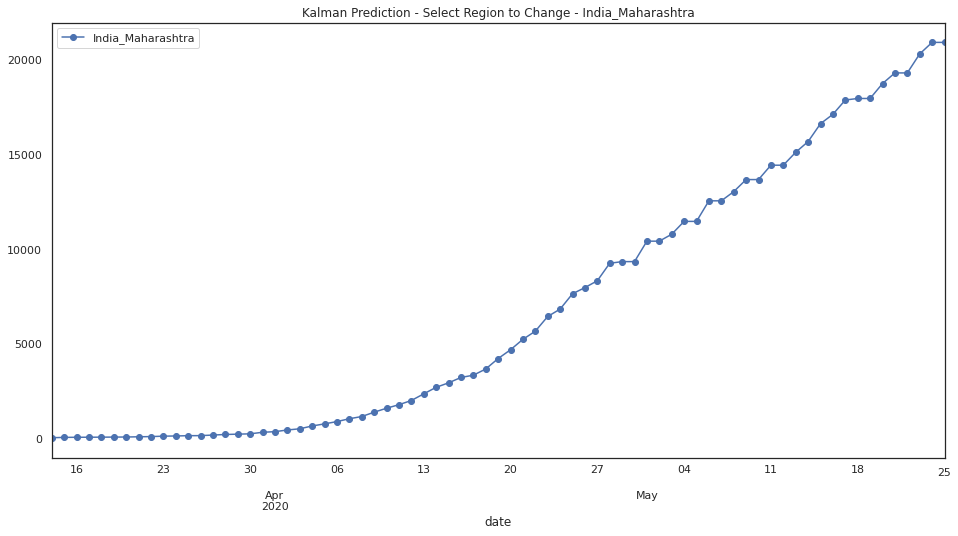

In [73]:
# Select region
region=['date','India_Andaman and Nicobar Islands','India_Andhra Pradesh','India_Arunachal Pradesh','India_Assam','India_Bihar','India_Chandigarh','India_Chattisgarh','India_Dadra and Nagar Haveli','India_Daman and Diu','India_Delhi','India_Goa','India_Gujarat','India_Haryana','India_Himachal Pradesh','India_Jammu and Kashmir','India_Jharkhand','India_Karnataka','India_Kerala','India_Ladakh','India_Lakshadweep','India_Madhya Pradesh','India_Maharashtra','India_Manipur','India_Meghalaya','India_Mizoram','India_Nagaland','India_Odisha','India_Puducherry','India_Punjab','India_Rajasthan','India_Sikkim','India_Tamil Nadu','India_Telangana','India_Tripura','India_Uttar Pradesh','India_Uttarakhand','India_West Bengal']
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction').figure.savefig('img10.png')

p_kalman2=all_new[['date','India_Maharashtra']]
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p_kalman2.columns[0])).figure.savefig('img11.png')

prediction_one_month = p_kalman2.tail(30)
prediction_two_weeks = prediction_one_month.tail(30)
prediction_two_weeks


## Prediction Heatmap

In [0]:
pip install gmplot

In [0]:
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [0]:
heatmap=confirmed[['region','Lat','Long']]
hold=confirmed[['region']]
# print(hold)
temp=pred.T
p_m=pd.DataFrame(temp)
p_m=p_m.reset_index()
hold['tmp']=1
p_m['tmp']=1
p_m=pd.merge(hold,p_m,on=['tmp'])
p_m=p_m.drop('tmp',axis=1)
# print(p_m)
heatmap_m=heatmap.merge(p_m,how='left',on='region')
# print(heatmap_m)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
heatmap_m.columns.values[0] #9/30/61

'region'

In [0]:
heatmap=pd.DataFrame()
for i in range(0,len(heatmap_m)):
  if heatmap_m.iloc[i,3].astype(int)==0: # heatmap_m.iloc[i,9] columns is the date we want to check
    continue
  #heatmap=heatmap.append(pd.concat([heatmap_m.iloc[i:(i+1),:]]*abs(heatmap_m.iloc[i,30].astype(int)), ignore_index=True,sort=False))
  heatmap=heatmap.append(pd.concat([heatmap_m.iloc[i:(i+1),1:3]]*abs(heatmap_m.iloc[i,3].astype(int)), ignore_index=True,sort=False))

In [0]:
latitudes = heatmap['Lat']
longitudes = heatmap['Long']
# Creating the location we would like to initialize the focus on. 
# Parameters: Lattitude, Longitude, Zoom
gmap = gmplot.GoogleMapPlotter(30.97564, 112.2707, 5)
gmap.heatmap(latitudes, longitudes)
# Generate the heatmap into an HTML file
gmap.draw("Heatmap4-2020-04-23.html")
# print("raghav")
# import os
# os.system('Heatmap4-2020-04-24.html')